In [ ]:
!git clone https://<username>:<password>@github.com/grubdragon/ME766_Project.git
%cd ME766_Project
!git pull

Cloning into 'ME766_Project'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 23 (delta 11), reused 19 (delta 7), pack-reused 0
Unpacking objects: 100% (23/23), done.
/content/ME766_Project
Already up to date.


In [ ]:
!pip install torchdiffeq

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import torch
import torch.nn as nn

In [ ]:
from model import mma_process
from util import *

In [ ]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [ ]:
dtype = torch.float

device = torch.device("cpu")
#device = torch.device("cuda:0") # Uncomment this to run on GPU

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
mma = mma_process()

In [ ]:
# Set simulation parameters
tk  = 0.0 ;       # Time
samp_T = 0.008;   # (hrs)sampling interval
N_samples = 1000; # No of samples

In [ ]:
mma.F

tensor(1., device='cuda:0')

# Kalman Filter implementation

In [ ]:
t1 = time.time()

In [ ]:
from scipy.optimize import fsolve
# Find steady state operating point to linearize our given model

# the initial guess for steady-state states
mma.Xs0 = torch.tensor([5.9655, 
                        0.0249, 
                        0.0020, 
                        50.3287, 
                        351.4013, 
                        332.90774], dtype=dtype, device=device)

# the given steady-state input
mma.Uk = torch.tensor([mma.F, mma.F_cw], dtype=dtype, device=device)

# Using fsolve to solve for dx/dt=0
mma.Xs = torch.as_tensor(fsolve(mma.ss, mma.Xs0.cpu()), dtype=dtype, device=device)

In [ ]:
mma.dyn(0, mma.Xs)

tensor([-9.5367e-07, -5.1223e-09, -7.4506e-09, -1.2207e-04,  1.3733e-04,
        -3.6621e-04], device='cuda:0')

In [ ]:
# Jacobian calculation

#defining some helper variables
mma.C_mat = torch.tensor([[0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]], dtype=dtype, device=device) # Measurement matrix
mma.Ys = torch.matmul(mma.C_mat, mma.Xs.reshape(-1,1)).reshape(-1)# the steady state measurements
mma.Us = mma.Uk # the steady state input
    
n_st = len( mma.Xs ) # No. of states
n_op =  len( mma.Ys ) # No. of measured o/p
n_ip = len( mma.Us ) # No. of manipulated inputs

In [ ]:
mma.Xs.shape

torch.Size([6])

In [ ]:
# Generate linear perturbation model at the current steady state

Z_vec = torch.cat((mma.Xs, mma.Us), 0) # The linearization point
# Now computing the Jacobian w.r.t. states and inputs. These matrices will
# be computed by a central difference scheme (numerical perturation)
# Matlab's jacobian function can also be used for computing the jacobian.
# It will perform analytical differentiation using symbolic variables.

#Jacob_mat = num_jacobian(mma.ss, Z_vec.cpu()); 
Jacob_mat = torch.autograd.functional.jacobian(mma.ss, Z_vec, create_graph=False, strict=False, vectorize=False)

In [ ]:
n_st

6

In [ ]:
Jacob_mat[:,0:n_st].shape

torch.Size([8, 6])

In [ ]:
# Continuous time linear perturbation model
A_mat = Jacob_mat[:n_st,:n_st]
B_mat  = Jacob_mat[:n_st, n_st:n_st+n_ip]
C_mat = Jacob_mat[n_st:n_st+n_ip,:n_st]
D_mat = Jacob_mat[n_st:n_st+n_ip, n_st:n_st+n_ip]

In [ ]:
A_mat.shape, B_mat.shape, C_mat.shape, D_mat.shape

(torch.Size([6, 6]),
 torch.Size([6, 2]),
 torch.Size([2, 6]),
 torch.Size([2, 2]))

In [ ]:
from scipy.signal import cont2discrete as c2d

# Generate discrete time linear perturbation model
dmod = c2d((A_mat.cpu(), B_mat.cpu(), C_mat.cpu(), D_mat.cpu()), samp_T)

phi = torch.as_tensor(dmod[0], dtype=dtype, device=device)
gama = torch.as_tensor(dmod[1], dtype=dtype, device=device)
C_mat = torch.as_tensor(dmod[2], dtype=dtype, device=device)
D_mat = torch.as_tensor(dmod[3], dtype=dtype, device=device)
dt = torch.as_tensor(dmod[4], dtype=dtype, device=device)

## True State Generation

In [ ]:

R_mat = torch.diag(torch.tensor([2.5e-1, 2.5e-1], dtype=dtype, device=device)); # Covariance matrix of measurement noise
Q_mat = torch.diag(torch.tensor([3.2028e-6, 
                                6.2e-12,
                                25e-14,
                                25.28e-6, 
                                12.34e-4, 
                                11.08e-4], dtype=dtype, device=device)); # Covariance matrix of state noise

In [ ]:
torch.manual_seed(0) # Seeding the random number generator

In [ ]:
from torch.distributions.multivariate_normal import MultivariateNormal

state_noise = MultivariateNormal(loc = torch.zeros((n_st,), dtype=dtype, device=device), covariance_matrix = Q_mat)
measurement_noise = MultivariateNormal(loc = torch.zeros((n_op,), dtype=dtype, device=device), covariance_matrix = R_mat)

In [ ]:
wk =  state_noise.sample() # state noise vector
vk =  measurement_noise.sample() # measurement noise vector

In [ ]:
mma.Xk = mma.Xs0 + wk     
mma.Yk = torch.matmul(C_mat, mma.Xs0.reshape(-1,1)).reshape(-1) +vk #
mma.Uk = mma.Us

In [ ]:
Xktrue = torch.zeros(n_st, N_samples, dtype=dtype, device=device) # for storing true states
Yk = torch.zeros(n_op, N_samples, dtype=dtype, device=device) # for storing outputs
timek = torch.zeros((N_samples,), dtype=dtype, device=device) # for storing outputs

In [ ]:
from torchdiffeq import odeint

In [ ]:
time_interval = torch.linspace(float(0), float(samp_T), 50, dtype=dtype, device=device)

In [ ]:
%timeit
for k in range(N_samples):
    
    # Save data at instant for display and analysis
    timek[k] = (k-1)*samp_T
    Xktrue[:, k] =  mma.Xk # Saving the true states ....
    Yk[:,k] = mma.Yk # and the measurements ...
    
    # Process Simulation from sampling instant k to (k+1)
    X0 = mma.Xk # Reset initial 
    
    #time_interval = torch.linspace(float(0), float(samp_T), 50)
    Xt = odeint(mma.dyn, X0, time_interval)
    wk =  state_noise.sample() # state noise vector
    vk =  measurement_noise.sample() # measurement noise vector
    
    mma.Xk = Xt[-1,:] + wk      # state at sampling instant (k+1)
    mma.Yk = torch.matmul(mma.C_mat, mma.Xk) + vk

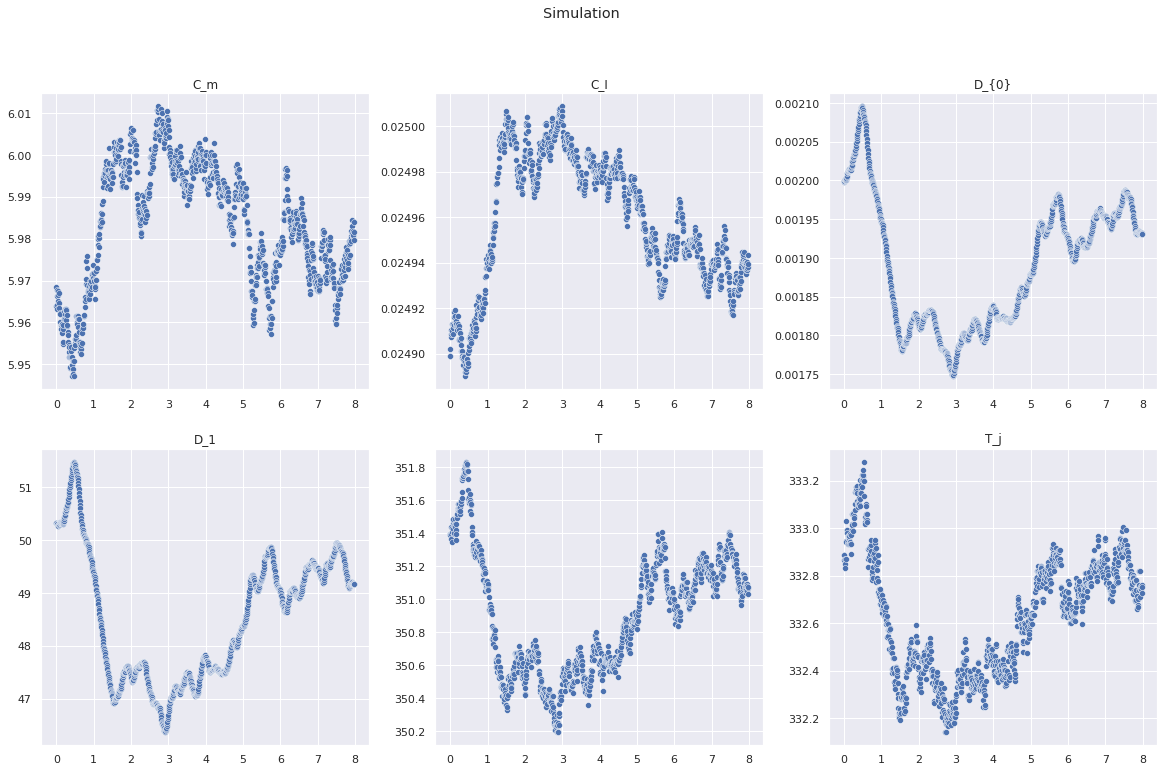

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20,12))

plot_titles = ["C_m","C_I","D_{0}","D_1","T","T_j"]

for i, ax in zip(range(6), axes.flat):
    sns.scatterplot(x=timek.cpu(), y=Xktrue[i,:].cpu(), ax=ax)
    #sns.lineplot(x=timek, y=Xktrue[i,:], ax=ax)
    #sns.lineplot(x=timek, y=XkKF[i,:], ax=ax)
    ax.title.set_text(plot_titles[i])

fig.suptitle('Simulation')
plt.show()

In [ ]:
factor = 100
N_ST = n_st * factor
N_OP = n_op * factor

Q_list = [Q_mat]*factor
Q_large = torch.block_diag(*Q_list).to(device)

R_list = [R_mat]*factor
R_large = torch.block_diag(*R_list).to(device)

phi_list = [phi]*factor
phi_large = torch.block_diag(*phi_list).to(device)

C_list = [mma.C_mat]*factor
C_large = torch.block_diag(*C_list).to(device)

## Applying Kalman Filter

In [ ]:
xkhatKF = torch.zeros(N_ST, N_samples, dtype=dtype, device=device) # for storing filtered states
xkpredKF = torch.zeros(N_ST, N_samples, dtype=dtype, device=device) # for storing predicted states
ekKF = torch.zeros(N_OP, N_samples, dtype=dtype, device=device) # for storing innovations
pkhat_listKF = torch.zeros(N_ST, N_ST, N_samples, dtype=dtype, device=device) # for storing filtered covariances
yk = torch.zeros(N_OP, N_samples, dtype=dtype, device=device) # for storing measurements

In [ ]:
rad_pkhatKF = torch.zeros(N_samples, 1, dtype=dtype, device=device) # for storing filtered covariances' spectral radii
rad_pkpredKF = torch.zeros(N_samples, 1, dtype=dtype, device=device) # for storing predicted covariances' spectral radii
betakKF = torch.zeros(N_samples, 1, dtype=dtype, device=device) # for storing NEES

In [ ]:
xkhatKF[:, 0] = (1.025 * Xktrue[:, 0] - mma.Xs).repeat(factor) # Initial perturbation state

pkhat = 10 * Q_large # initializing the filtered covariance matrix
pkhat_listKF[:, :, 0] = pkhat

In [ ]:
rad_pkhatKF[0] = radius(pkhat)
betakKF[0] = torch.reshape(0.025 * Xktrue[:, 0], (1, -1)).matmul(torch.linalg.inv(pkhat)).matmul(0.025*Xktrue[:,1])#

In [ ]:
times = torch.zeros(5, N_samples)

In [ ]:
t2 = time.time()

for k in range(1, N_samples):
    tx1 = time.time()
    xkpredKF[:, k] = phi_large.mm(xkhatKF[:, k-1].reshape(-1,1)).reshape(-1)
    pkpred = phi_large.mm(pkhat).mm(torch.transpose(phi_large, 0, 1)) + Q_large

    tx2 = time.time()
    yk[:, k] = (Yk[:, k]- mma.Ys).repeat(factor)
    L_mat = pkpred\
            .mm(torch.transpose(C_large, 0, 1))\
            .mm(torch.linalg.inv(C_large.mm(pkpred).mm(C_large.transpose(0, 1)) + R_large))
    
    tx3 = time.time()
    ekKF[:, k] = yk[:, k] - C_large.matmul(xkpredKF[:, k])
    xkhatKF[:, k] = xkpredKF[:, k] + L_mat.matmul(ekKF[:, k])
    pkhat = (torch.eye(N_ST, dtype=dtype, device=device) - torch.matmul(L_mat, C_large)).matmul(pkpred)
    
    tx4 = time.time()
    pkhat_listKF[:, :, k] = pkhat
    rad_pkpredKF[k] = radius(pkpred)
    rad_pkhatKF[k] = radius(pkhat)
    
    tx5 = time.time()
    betakKF[k] = torch.reshape(xkhatKF[:, k] + mma.Xs - Xktrue[:, k], (1,-1))\
    .matmul(torch.linalg.inv(pkhat))\
    .matmul(xkhatKF[:, k] + mma.Xs - Xktrue[:, k])
    
    tx6 = time.time()
    
    times[0,k] = tx2-tx1
    times[1,k] = tx3-tx2
    times[2,k] = tx4-tx3
    times[3,k] = tx5-tx4
    times[4,k] = tx6-tx5
t3 = time.time()

In [ ]:
torch.mean(times, axis=1)

tensor([1.6133e-04, 2.5017e-03, 2.0529e-04, 5.4705e-02, 1.2341e-06])

In [ ]:
# Time for loop
t3-t2

57.61241269111633

In [ ]:
# Time for Kalman Filter
# t3-t1

NameError: ignored

In [ ]:
XkKF = (xkhatKF + mma.Xs.repeat(factor).reshape(-1,1)) # the KF estimates converted to original form

In [ ]:
 mma.Xs.repeat(2)

tensor([5.9738e+00, 2.4937e-02, 1.9538e-03, 4.9460e+01, 3.5117e+02, 3.3281e+02,
        5.9738e+00, 2.4937e-02, 1.9538e-03, 4.9460e+01, 3.5117e+02, 3.3281e+02],
       device='cuda:0')

## Plots

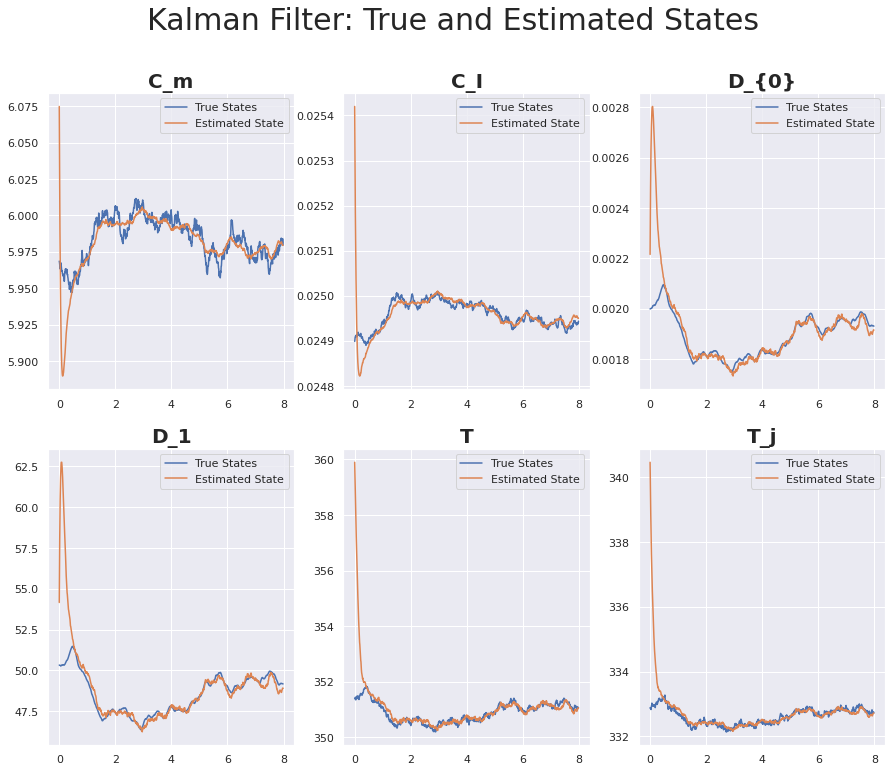

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15,12))

plot_titles = ["C_m","C_I","D_0","D_1","T","T_j"]

for i, ax in zip(range(6), axes.flat):
    sns.lineplot(x=timek[1:].cpu(), y=Xktrue[i,1:].cpu(), ax=ax)
    sns.lineplot(x=timek[1:].cpu(), y=XkKF[i,1:].cpu(), ax=ax)
    #sns.lineplot(x=timek.cpu(), y=(mma.Xs + xkhatKF[i,:]).cpu(), ax=ax)
    ax.set_title(str(plot_titles[i]),fontweight="bold", size=20)
    ax.legend(['True States','Estimated State'])
    #ax.title.set_text(plot_titles[i])

fig.suptitle('Kalman Filter: True and Estimated States',fontsize=30)

plt.show()

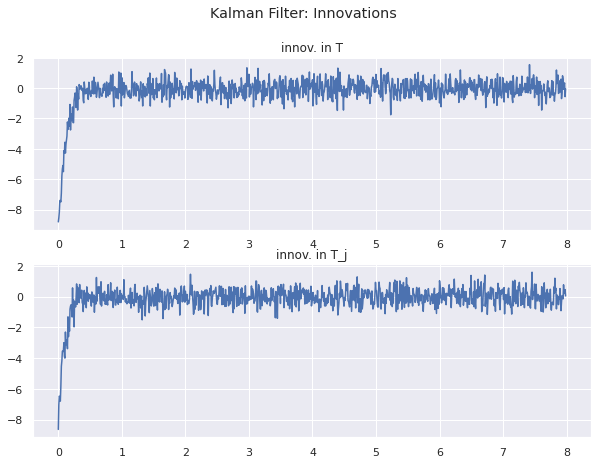

In [ ]:
# Plotting innovation e_i (k) (defined as given measurement minus
# predicted measurement using the predicted state)

fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,7))

plot_titles = ['innov. in T','innov. in T_j']

for i, ax in zip(range(2), axes.flat):
    sns.lineplot(x=timek[1:].cpu(), y=ekKF[i,1:].cpu(), ax=ax)
    ax.xlabel = 'Time, hours'
    ax.ylabel = plot_titles[i]
    ax.title.set_text(plot_titles[i])

fig.suptitle('Kalman Filter: Innovations')
plt.show()

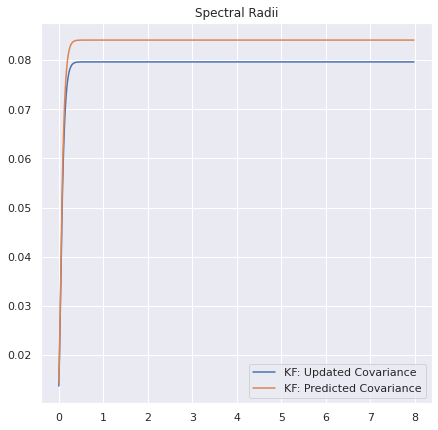

In [ ]:
# Plotting innovation e_i (k) (defined as given measurement minus
# predicted measurement using the predicted state)

fig = plt.figure(figsize=(7,7))

plt.title('Spectral Radii')

sns.lineplot(x=timek[1:].cpu(), y=rad_pkhatKF[1:].reshape(-1).cpu())
sns.lineplot(x=timek[1:].cpu(), y=rad_pkpredKF[1:].reshape(-1).cpu())

plt.xlabel = 'Time, hours'
plt.ylabel = 'Spectral Radius'

plt.legend(['KF: Updated Covariance','KF: Predicted Covariance'])

plt.show()

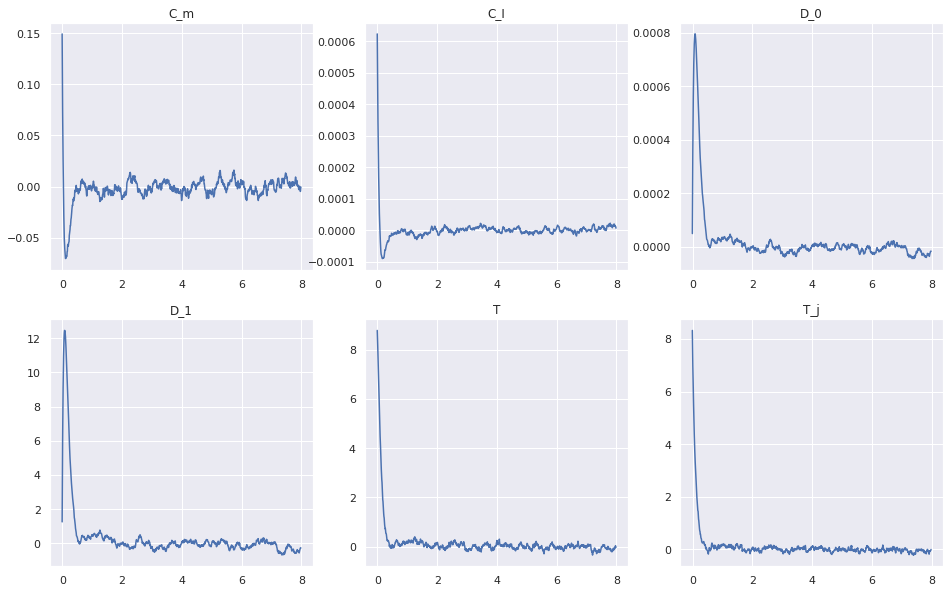

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16,10))

plot_titles = ["C_m","C_I","D_0","D_1","T","T_j"]

for i, ax in zip(range(6), axes.flat):
    sns.lineplot(x=timek.cpu(), y=(XkKF[i,:] - Xktrue[i,:]).cpu(), ax=ax)
    ax.legend = ['Error: KF']
    ax.xlabel = 'Time, hours'
    ax.title.set_text(plot_titles[i])

plt.show()

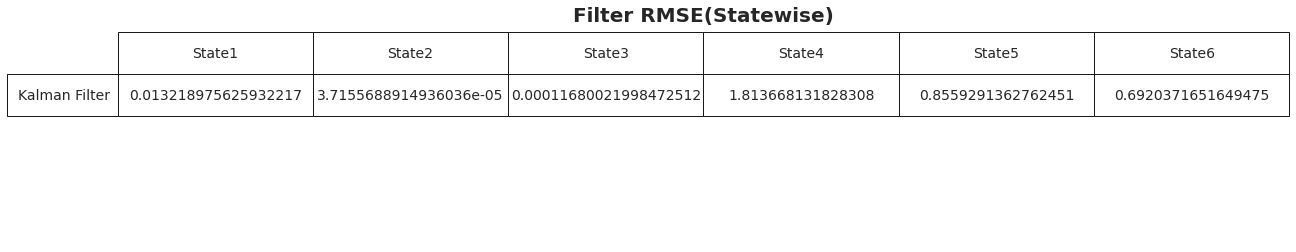

In [ ]:
# Summarize RMSE of Filters
RMSE_list = torch.sqrt(torch.mean(torch.pow(XkKF[:n_st,]-Xktrue,2), axis=1)).reshape(1,-1).tolist()
row_labels = ["Kalman Filter"]
col_labels = ["State{:X}".format(i+1) for i in range(6)]

ax = plt.gca()
ax.set_axis_off()
table = ax.table(
    cellText = RMSE_list, 
    rowLabels = row_labels, 
    colLabels = col_labels,
    cellLoc ='center',
    loc='upper center')        

table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(3.5, 3.5)
ax.set_title('Filter RMSE(Statewise)',
             fontweight ="bold", fontsize=20)
  
plt.show()


In [ ]:
figure(5);
sgtitle('Normalized Estimation Error Squared (NEES)');
plot(timek,betakKF), grid on;
yline(et1);
yline(et2);
xlabel('Time, hours');

% Initailize plotting style: Set parameters for graphical display
set(0,'DefaultLineLineWidth', 1)
set(0,'DefaultaxesLineWidth', 1)
set(0,'DefaultaxesFontSize', 16)
set(0,'DefaultTextFontSize', 16)
set(0,'DefaultaxesFontName', 'arial')


% Summarize mean and variance of innovations
FilterNames = {'KF'};
Mean_e1 = [mean(ekKF(1,:))];
Var_e1 = [var(ekKF(1,:))];
Mean_e2 = [mean(ekKF(2,:))];
Var_e2 = [var(ekKF(2,:))];
T1 = table(Mean_e1,Var_e1,Mean_e2,Var_e2,'RowNames',FilterNames);
disp('Mean and Variance of Innovations')
disp(T1)

fprintf('\n')


% Normalized Estimation Error Squared (NEES) for each filter
et1 = chi2inv(0.05, n_st);
et2 = chi2inv(1-0.05, n_st);

figure(5);
sgtitle('Normalized Estimation Error Squared (NEES)');
plot(timek,betakKF), grid on;
yline(et1);
yline(et2);
xlabel('Time, hours');

% consistency fraction calculation
frac_KF = (sum(betakKF > et2) + sum(betakKF < et1))/N_samples;
if (frac_KF <= 0.05)
    fprintf('The filter is consistent with out-of-bounds fraction: %f\n', frac_KF);
else
    fprintf('The filter is INconsistent with out-of-bounds fraction: %f\n', frac_KF);
end

In [ ]:
device

device(type='cuda')

In [ ]:
!nvidia-smi

Sat May  8 14:25:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    27W /  70W |   2454MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------